In [2]:
import sys
sys.path.append("../..")
import itertools

import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt

from src.data.preprocess_data import preprocess
from src.utils.utils import get_gene_list_real_data, nanmean,get_test_statistics

sc.settings.verbosity = 1

In [3]:
# adata_healthy = sc.read_h5ad('../data/real_data/healthy.h5ad')
# adata_unhealthy = sc.read_h5ad('../data/real_data/unhealthy.h5ad')
# adata = adata_healthy.concatenate(adata_unhealthy)

In [4]:
# dict_samples = {}

In [5]:
# for group in adata.obs.groupby(by='sample_id'):
#     dict_samples[group[0]] = adata[group[1].index, :].copy()

In [6]:
# del adata
# del adata_unhealthy
# del adata_healthy

In [7]:
# dict_samples.keys()

In [8]:
# adata = dict_samples['P23T']
adata = sc.read_h5ad('../data/real_data/P23T_adata.h5ad')

In [9]:
adata = adata[adata.obs['healthy']!='undecided',:]

In [10]:
preprocess(adata, min_genes=500, min_cells=10, target_sum=1e4, copy=False, verbose=1, log=None)

Trying to set attribute `.obs` of view, copying.


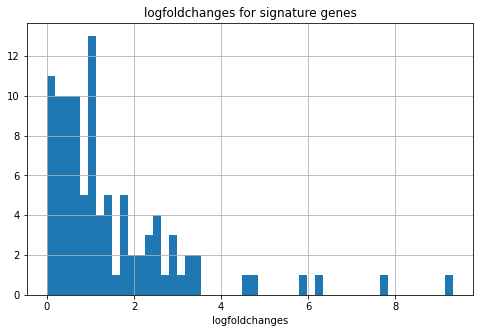

In [11]:
gene_list = get_gene_list_real_data(
    adata,
    dge_method="wilcoxon",
    dge_key="wilcoxon",
    dge_pval_cutoff=0.01,
    dge_log2fc_min=0.0025,
    nr_de_genes=100,
    mode="random",
    log='get_gene_list',
    copy=False,
    verbose=1
)

In [12]:
all_diffexp = sc.get.rank_genes_groups_df(
    adata,
    group="unhealthy",
    key='wilcoxon'
)

In [13]:
all_diffexp = all_diffexp.sort_values(by='names',ascending=True)

In [14]:
adata

AnnData object with n_obs × n_vars = 3478 × 14044
    obs: 'sample_id', 'celltype', 'batch', 'healthy_annotation', 'reference', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'pct_zero_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'reference_type', 'healthy_cnv', 'healthy', 'S_score', 'G2M_score', 'phase', 'apoptosis_score', 'oxphos', 'AP', 'Cycling', 'Epi1', 'Epi2', 'Mes', 'Mucosal', 'Oxd', 'Stress', 'subclonal'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chromosome', 'start', 'end', 'cutoff', 'n_cells'
    uns: 'cnv', 'reference_cat', 'reference_info', 'log1p', 'wilcoxon'
    obsm: 'X_cnv'

Get ranked means, take neighbors

In [15]:
obs_avg = pd.Series(nanmean(adata.X, axis=0), index=adata.var_names)
obs_avg = obs_avg[np.isfinite(obs_avg)]

# correct computations of cuts
ranked_obs_avg = obs_avg.rank(method="min").sort_values()

In [16]:
ranked_ref_genes = ranked_obs_avg[ranked_obs_avg.index.isin(gene_list)==False]

In [17]:
ctrl_genes = 100

In [18]:
ctrl_genes_half = int(np.round(ctrl_genes/2))

In [19]:
ctrl_genes_list = []
for val in ranked_obs_avg.loc[gene_list]:
    idx_where_insert = ranked_ref_genes.searchsorted(val)
    lower = idx_where_insert-ctrl_genes_half
    upper = idx_where_insert+ctrl_genes_half
    if lower <0:
        lower = 0
    if upper > ranked_ref_genes.shape[0]:
        upper = ranked_ref_genes.shape[0]
    ctrl_genes =  ranked_ref_genes.iloc[lower: upper]
    ctrl_genes_list.append(ctrl_genes.index.tolist())

In [20]:
ctrl_genes_list = list(itertools.chain(*ctrl_genes_list))

In [21]:
X_list = adata[:, gene_list].X
X_list = nanmean(X_list, axis=1, dtype="float64")

X_control = adata[:, ctrl_genes_list].X
X_control = nanmean(X_control, axis=1, dtype="float64")

score = X_list - X_control

In [22]:
score

array([-0.01949321, -0.03499063, -0.02355757, ..., -0.00992444,
        0.0304405 , -0.00997081])

In [23]:
adata.obs["no_binning"] = pd.Series(
        np.array(score).ravel(), index=adata.obs_names, dtype="float64"
    )

In [24]:
from src.scoring_methods.tirosh_signature_scoring import score_genes as tirosh_scoring
from src.scoring_methods.neighborhood_signature_scoring import score_genes as neighborhood_scoring

In [25]:
tirosh_scoring(
        adata,
        gene_list,
        n_bins=25,
        ctrl_size=100,
        verbose=0,
        score_name="Tirosh scoring",
        random_state=5,
    )

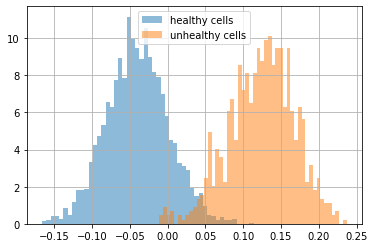

In [26]:
adata.obs["no_binning"][adata.obs["healthy"]=='healthy'].hist(bins=50, density=True, label="healthy cells", alpha=0.5)
adata.obs["no_binning"][adata.obs["healthy"]=='unhealthy'].hist(bins=50,density=True, label="unhealthy cells", alpha=0.5)
plt.legend()

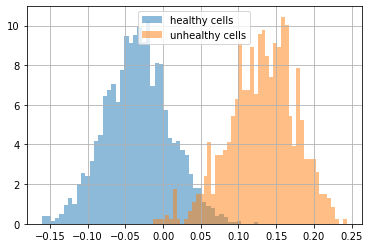

In [27]:
adata.obs["Tirosh scoring"][adata.obs["healthy"]=='healthy'].hist(bins=50, density=True, label="healthy cells", alpha=0.5)
adata.obs["Tirosh scoring"][adata.obs["healthy"]=='unhealthy'].hist(bins=50,density=True, label="unhealthy cells", alpha=0.5)
plt.legend()

In [28]:
neighborhood_scoring(
        adata,
        gene_list,
        ctrl_size=100,
        verbose=0,
        score_name="no_binning_2",
        random_state=1000,
    )

In [29]:
adata.obs[["no_binning","no_binning_2"]]

,no_binning,no_binning_2
index,,
P23T-I-AAACGGGAGGCCATAG-0,-0.019493,-0.019493
P23T-I-AAAGATGAGCACACAG-0,-0.034991,-0.034990
P23T-I-AAAGCAACAGCGTTCG-0,-0.023558,-0.023557
P23T-I-AAAGCAATCAGTGCAT-0,-0.005874,-0.005874
P23T-I-AAAGTAGTCGTCTGAA-0,-0.051732,-0.051732
...,...,...
P23T-E-TTGGAACAGAATGTGT-7,-0.007081,-0.007081
P23T-E-TTGGAACAGTGTCCAT-7,0.013008,0.013009
P23T-E-TTGTAGGAGTCCATAC-7,-0.009924,-0.009925


In [30]:
test_stat = get_test_statistics(adata,
                                ['Tirosh scoring', 'no_binning', 'no_binning_2'],
                                test_method="auc",
                                label_col='healthy',
                                label_whsc='unhealthy',
                                save=False,
                                store_data_path=None)
test_stat = get_test_statistics(adata,
                                ['Tirosh scoring', 'no_binning', 'no_binning_2'],
                                test_method="kstest",
                                label_col='healthy',
                                label_whsc='unhealthy',
                                old_df = test_stat,
                                save=False,
                                store_data_path=None)
test_stat = get_test_statistics(adata,
                                ['Tirosh scoring', 'no_binning', 'no_binning_2'],
                                test_method='mannwhitneyu',
                                label_col='healthy',
                                label_whsc='unhealthy',
                                old_df = test_stat,
                                save=False,
                                store_data_path=None)
test_stat

,Scoring method,Test method,Statistic,pvalue
0,tirosh_scoring,auc,9.951947e-01,NaN
1,no_binning,auc,9.958651e-01,NaN
2,no_binning_2,auc,9.958651e-01,NaN
3,tirosh_scoring,kstest,0.000000e+00,1.0
4,no_binning,kstest,0.000000e+00,1.0
5,no_binning_2,kstest,0.000000e+00,1.0
6,tirosh_scoring,mannwhitneyu,2.304032e+06,0.0
7,no_binning,mannwhitneyu,2.305584e+06,0.0
8,no_binning_2,mannwhitneyu,2.305584e+06,0.0
